# Week 3 - Network Models

In [1]:
import numpy as np
import pandas as pd
from pulp import *

## 1) Transportation problem

An automobile company manufactures cars in 3 plants and then ships them to 4 regions.   
The plants can supply the amount listed in `capacity`.  
The customer demands by region are listed in `demand`.  
And the unit costs of shipping a car from each plant to each region are listed in `unit costs`.  
The company wants to find the lowest-cost shipping plan for meeting the demands of the four regions without exceeding the capacities of the plants.

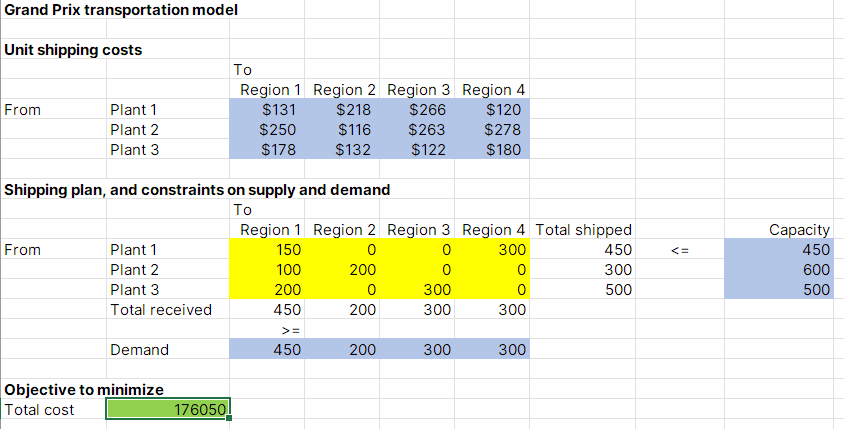

### Input parameters

In [5]:
# i - plants
# j - regions
unit_costs = np.array([
    [131, 218, 266, 120],
    [250, 116, 263, 278],
    [178, 132, 122, 180]
])
plants = [ f"Plant{i}" for i in range(1,4) ]
regions = [ f"Region{j}" for j in range(1,5) ]

capacity = np.array([450, 600, 500])
capacity = dict(zip(plants, capacity))
print('Capacity:\n', capacity)
demand = np.array([450, 200, 300, 300])
demand = dict(zip(regions, demand))
print('Demand:\n', demand)

Capacity:
 {'Plant1': 450, 'Plant2': 600, 'Plant3': 500}
Demand:
 {'Region1': 450, 'Region2': 200, 'Region3': 300, 'Region4': 300}


In [6]:
unit_costs = pd.DataFrame(unit_costs, index=plants, columns=regions)
unit_costs

,Region1,Region2,Region3,Region4
Plant1,131,218,266,120
Plant2,250,116,263,278
Plant3,178,132,122,180


### Problem formulation

$\text{Decision variables}\\
x_{ij} = \text{flow from i to j for i = 1,2,3 and j = 1,2,3,4}
$

$\text{min}\quad \sum_{i=1}^3 \sum_{j=1}^{4} c_{ij} x_{ij}\\
\text{subject to:}$
\begin{align*}
\sum_{j=1}^4 x_{ij} & \leq b_i && \text{for i = 1, 2, 3} && \text{Capacity}\\
\sum_{i=1}^3 x_{ij} & \geq d_j && \text{for j = 1, 2, 3, 4} && \text{Demand}\\
x_{ij} & \geq 0 && \text{for i = 1, 2, 3 and j = 1, 2, 3, 4} && \text{Nonnegativity}
\end{align*}

### Solve

In [7]:
# Model creation
model = LpProblem('Transportation', LpMinimize)

# decision variables
decision_vars = LpVariable.matrix('x', [f"{i}{j}" for i in range(1,4) for j in range(1,5)], lowBound=0)
allocation = np.array(decision_vars).reshape(len(plants), len(regions))

# objective function
obj_func = lpSum(unit_costs.values * allocation)
model += obj_func

# for each plant, create capacity constraint
for i, plant in enumerate(plants):
    model += lpSum(allocation[i,:]) <= capacity[plant], f"Capactiy {plant}"
    
# for each region, create demand constraint
for j, region in enumerate(regions):
    model += lpSum(allocation[:,j]) >= demand[region], f"Demand {region}"

print(model)

# Solve Model
model.solve()
print(f"Status: {LpStatus[model.status]}")
print(f"Objective value: {model.objective.value()}")

Transportation:
MINIMIZE
131*x_11 + 218*x_12 + 266*x_13 + 120*x_14 + 250*x_21 + 116*x_22 + 263*x_23 + 278*x_24 + 178*x_31 + 132*x_32 + 122*x_33 + 180*x_34 + 0
SUBJECT TO
Capactiy_Plant1: x_11 + x_12 + x_13 + x_14 <= 450

Capactiy_Plant2: x_21 + x_22 + x_23 + x_24 <= 600

Capactiy_Plant3: x_31 + x_32 + x_33 + x_34 <= 500

Demand_Region1: x_11 + x_21 + x_31 >= 450

Demand_Region2: x_12 + x_22 + x_32 >= 200

Demand_Region3: x_13 + x_23 + x_33 >= 300

Demand_Region4: x_14 + x_24 + x_34 >= 300

VARIABLES
x_11 Continuous
x_12 Continuous
x_13 Continuous
x_14 Continuous
x_21 Continuous
x_22 Continuous
x_23 Continuous
x_24 Continuous
x_31 Continuous
x_32 Continuous
x_33 Continuous
x_34 Continuous

Status: Optimal
Objective value: 176050.0


### Result

In [9]:
result = np.array([ v.value() for v in model.variables()]).reshape(len(plants), len(regions))
result = pd.DataFrame(result, index=plants, columns=regions)
result

,Region1,Region2,Region3,Region4
Plant1,150.0,0.0,0.0,300.0
Plant2,100.0,200.0,0.0,0.0
Plant3,200.0,0.0,300.0,0.0


### Just for fun - visualizing network model result

Just tried it, difficult to use networkx. Trust me, it doesn't worth the effort. 😅

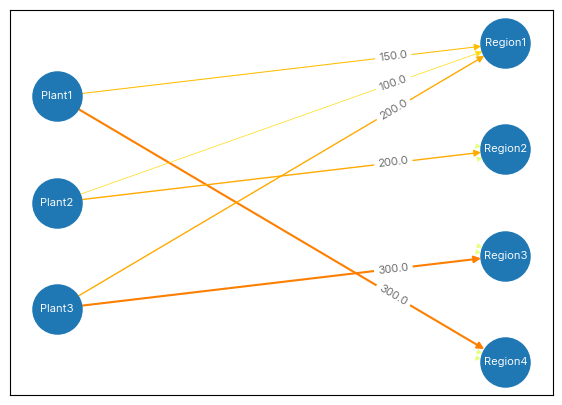

In [188]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.DiGraph()
G.add_nodes_from([(p, {'type': 0}) for p in plants])
G.add_nodes_from([(r, {'type': 1}) for r in regions])

df = result.rename_axis('origin').reset_index().melt(id_vars='origin', var_name='destination')
G.add_edges_from([(r.origin, r.destination, 
                   {
                    'weight': r.value/result.max().max(), 
                    'qty' : r.value 
                   }) for i,r in df.iterrows()])

plt.figure(figsize=(7,5), dpi=100)

edgelist, edge_weights = zip(*[ ((e[0],e[1]),e[2]['weight']) for e in G.edges(data=True)])
edge_labels = {(e[0],e[1]): str(e[2]['qty']) if e[2]['qty']>0 else '' for e in G.edges(data=True)}

pos = nx.multipartite_layout(G, subset_key='type')
nx.draw_networkx(G, pos, node_size=1250, 
                 font_size=8, font_family='Inter', font_color='white',
                 edgelist=edgelist, width=[w*1.5 for w in edge_weights], 
                 edge_color=edge_weights, edge_cmap=plt.get_cmap('Wistia'))
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_family='Inter', font_size=8, alpha=.6, label_pos=.25)
plt.show()

## 2) Transshipment Model

### Problem
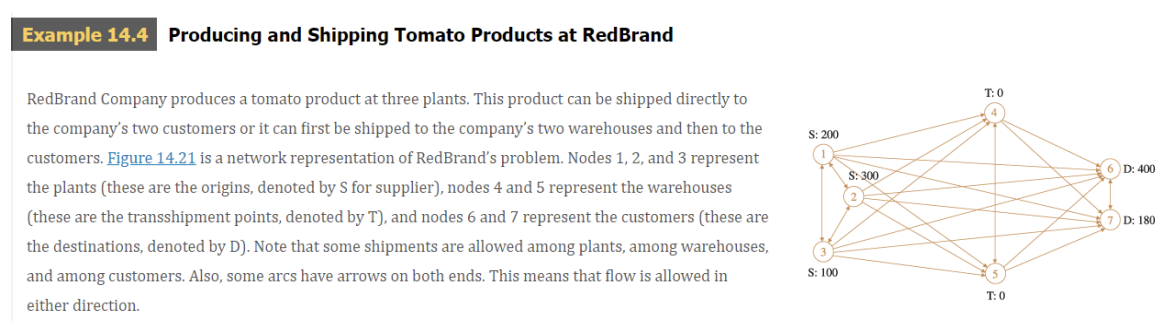

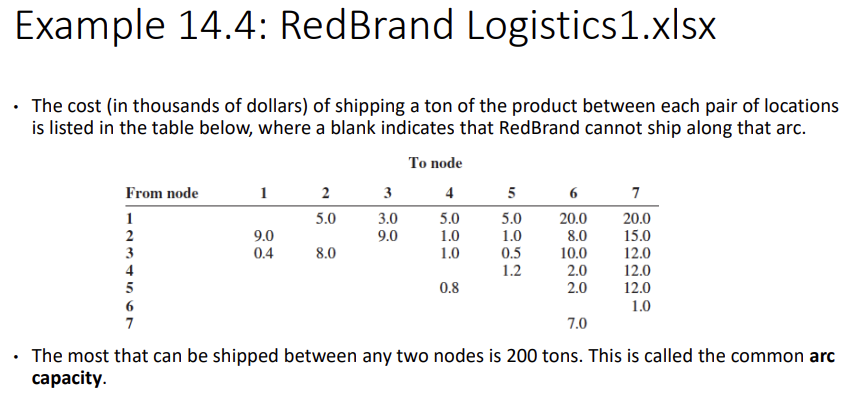

### Using Excel Solver
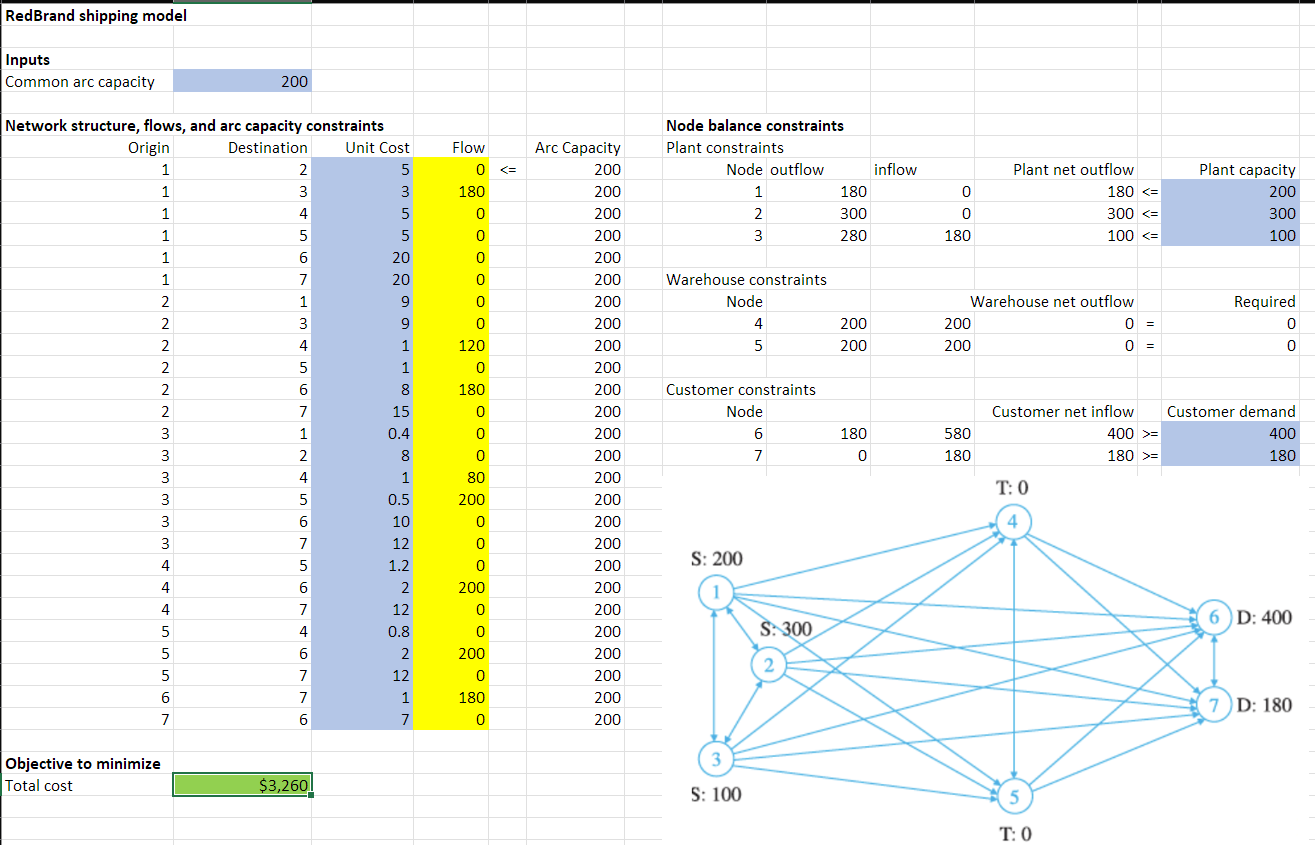

In [230]:
# load available routes and their corresponding unit costs
df = pd.read_csv('data/RedBrandLogistics.csv')
df.head()

,Origin,Destination,Unit Cost
0,1,2,5.0
1,1,3,3.0
2,1,4,5.0
3,1,5,5.0
4,1,6,20.0


In [226]:
# create unit cost dict using arc (route) as a key
routes = [ (int(r['Origin']), int(r['Destination'])) for i,r in df.iterrows() ]
costs = { (int(r['Origin']), int(r['Destination'])): r['Unit Cost'] for i, r in df.iterrows() }
costs

{(1, 2): 5.0,
 (1, 3): 3.0,
 (1, 4): 5.0,
 (1, 5): 5.0,
 (1, 6): 20.0,
 (1, 7): 20.0,
 (2, 1): 9.0,
 (2, 3): 9.0,
 (2, 4): 1.0,
 (2, 5): 1.0,
 (2, 6): 8.0,
 (2, 7): 15.0,
 (3, 1): 0.4,
 (3, 2): 8.0,
 (3, 4): 1.0,
 (3, 5): 0.5,
 (3, 6): 10.0,
 (3, 7): 12.0,
 (4, 5): 1.2,
 (4, 6): 2.0,
 (4, 7): 12.0,
 (5, 4): 0.8,
 (5, 6): 2.0,
 (5, 7): 12.0,
 (6, 7): 1.0,
 (7, 6): 7.0}

### Create decision variables

In [236]:
# decision variables using LpVariable.dicts
# variable names may look a bit weird, but
# the fact that we can access LpVariable using keys is quite beneficial
decision_vars = LpVariable.dicts('x', routes,lowBound=0)
decision_vars

{(1, 2): x_(1,_2),
 (1, 3): x_(1,_3),
 (1, 4): x_(1,_4),
 (1, 5): x_(1,_5),
 (1, 6): x_(1,_6),
 (1, 7): x_(1,_7),
 (2, 1): x_(2,_1),
 (2, 3): x_(2,_3),
 (2, 4): x_(2,_4),
 (2, 5): x_(2,_5),
 (2, 6): x_(2,_6),
 (2, 7): x_(2,_7),
 (3, 1): x_(3,_1),
 (3, 2): x_(3,_2),
 (3, 4): x_(3,_4),
 (3, 5): x_(3,_5),
 (3, 6): x_(3,_6),
 (3, 7): x_(3,_7),
 (4, 5): x_(4,_5),
 (4, 6): x_(4,_6),
 (4, 7): x_(4,_7),
 (5, 4): x_(5,_4),
 (5, 6): x_(5,_6),
 (5, 7): x_(5,_7),
 (6, 7): x_(6,_7),
 (7, 6): x_(7,_6)}

### Objective function

In [273]:
model = LpProblem('Transport', LpMinimize)

# Objective function: total cost = sum of cost * x
# This is where LpVariable.dicts() shines using key pars to access variables and input values
obj_func =  lpSum([costs[r] * decision_vars[r] for r in routes])
print(obj_func)
model += obj_func

5.0*x_(1,_2) + 3.0*x_(1,_3) + 5.0*x_(1,_4) + 5.0*x_(1,_5) + 20.0*x_(1,_6) + 20.0*x_(1,_7) + 9.0*x_(2,_1) + 9.0*x_(2,_3) + x_(2,_4) + x_(2,_5) + 8.0*x_(2,_6) + 15.0*x_(2,_7) + 0.4*x_(3,_1) + 8.0*x_(3,_2) + x_(3,_4) + 0.5*x_(3,_5) + 10.0*x_(3,_6) + 12.0*x_(3,_7) + 1.2*x_(4,_5) + 2.0*x_(4,_6) + 12.0*x_(4,_7) + 0.8*x_(5,_4) + 2.0*x_(5,_6) + 12.0*x_(5,_7) + x_(6,_7) + 7.0*x_(7,_6)


### Route capacity constraints
Each route (arc) has capacity of 200.

In [275]:
for r in routes:
    g = decision_vars[r] <= 200
    print(g)
    model += g

x_(1,_2) <= 200
x_(1,_3) <= 200
x_(1,_4) <= 200
x_(1,_5) <= 200
x_(1,_6) <= 200
x_(1,_7) <= 200
x_(2,_1) <= 200
x_(2,_3) <= 200
x_(2,_4) <= 200
x_(2,_5) <= 200
x_(2,_6) <= 200
x_(2,_7) <= 200
x_(3,_1) <= 200
x_(3,_2) <= 200
x_(3,_4) <= 200
x_(3,_5) <= 200
x_(3,_6) <= 200
x_(3,_7) <= 200
x_(4,_5) <= 200
x_(4,_6) <= 200
x_(4,_7) <= 200
x_(5,_4) <= 200
x_(5,_6) <= 200
x_(5,_7) <= 200
x_(6,_7) <= 200
x_(7,_6) <= 200


### Supply constraints

outflow - inflow <= plant capacity

In [276]:
# Plant capacity
plant_capacity = { 1 : 200, 2: 300, 3: 100 }

# outflow - inflow <= plant_capacity
for plant, capacity in plant_capacity.items():
    g = lpSum([decision_vars[r] for r in routes if r[0]==plant]) - lpSum([decision_vars[r] for r in routes if r[1]==plant]) <= capacity
    print(g)
    model += g

x_(1,_2) + x_(1,_3) + x_(1,_4) + x_(1,_5) + x_(1,_6) + x_(1,_7) - x_(2,_1) - x_(3,_1) <= 200
-x_(1,_2) + x_(2,_1) + x_(2,_3) + x_(2,_4) + x_(2,_5) + x_(2,_6) + x_(2,_7) - x_(3,_2) <= 300
-x_(1,_3) - x_(2,_3) + x_(3,_1) + x_(3,_2) + x_(3,_4) + x_(3,_5) + x_(3,_6) + x_(3,_7) <= 100


### Demand constraints

inflow - outflow >= demand

In [277]:
# Customer demand
cust_demand = { 6: 400, 7: 180 }

# inflow - outflow >= demand
for cust, demand in cust_demand.items():
    g = lpSum([decision_vars[r] for r in routes if r[1]==cust]) - lpSum([decision_vars[r] for r in routes if r[0]==cust]) >= demand
    print(g)
    model += g

x_(1,_6) + x_(2,_6) + x_(3,_6) + x_(4,_6) + x_(5,_6) - x_(6,_7) + x_(7,_6) >= 400
x_(1,_7) + x_(2,_7) + x_(3,_7) + x_(4,_7) + x_(5,_7) + x_(6,_7) - x_(7,_6) >= 180


### Transshipment constratins
outflow - inflow = 0

In [278]:
transshipment = [4, 5]
for t in transshipment:
    g = lpSum([decision_vars[r] for r in routes if r[0]==t]) - lpSum([decision_vars[r] for r in routes if r[1]==t]) == 0
    print(g)
    model += g

-x_(1,_4) - x_(2,_4) - x_(3,_4) + x_(4,_5) + x_(4,_6) + x_(4,_7) - x_(5,_4) = 0
-x_(1,_5) - x_(2,_5) - x_(3,_5) - x_(4,_5) + x_(5,_4) + x_(5,_6) + x_(5,_7) = 0


### Review the created problem

In [269]:
model

Transport:
MINIMIZE
5.0*x_(1,_2) + 3.0*x_(1,_3) + 5.0*x_(1,_4) + 5.0*x_(1,_5) + 20.0*x_(1,_6) + 20.0*x_(1,_7) + 9.0*x_(2,_1) + 9.0*x_(2,_3) + 1.0*x_(2,_4) + 1.0*x_(2,_5) + 8.0*x_(2,_6) + 15.0*x_(2,_7) + 0.4*x_(3,_1) + 8.0*x_(3,_2) + 1.0*x_(3,_4) + 0.5*x_(3,_5) + 10.0*x_(3,_6) + 12.0*x_(3,_7) + 1.2*x_(4,_5) + 2.0*x_(4,_6) + 12.0*x_(4,_7) + 0.8*x_(5,_4) + 2.0*x_(5,_6) + 12.0*x_(5,_7) + 1.0*x_(6,_7) + 7.0*x_(7,_6) + 0.0
SUBJECT TO
_C1: x_(1,_2) + x_(1,_3) + x_(1,_4) + x_(1,_5) + x_(1,_6) + x_(1,_7)
 - x_(2,_1) - x_(3,_1) <= 200

_C2: - x_(1,_2) + x_(2,_1) + x_(2,_3) + x_(2,_4) + x_(2,_5) + x_(2,_6)
 + x_(2,_7) - x_(3,_2) <= 300

_C3: - x_(1,_3) - x_(2,_3) + x_(3,_1) + x_(3,_2) + x_(3,_4) + x_(3,_5)
 + x_(3,_6) + x_(3,_7) <= 100

_C4: x_(1,_6) + x_(2,_6) + x_(3,_6) + x_(4,_6) + x_(5,_6) - x_(6,_7)
 + x_(7,_6) >= 400

_C5: x_(1,_7) + x_(2,_7) + x_(3,_7) + x_(4,_7) + x_(5,_7) + x_(6,_7)
 - x_(7,_6) >= 180

_C6: - x_(1,_4) - x_(2,_4) - x_(3,_4) + x_(4,_5) + x_(4,_6) + x_(4,_7)
 - x_(5,_4) = 0

In [279]:
# Solve Model
model.solve()
print(f"Status: {LpStatus[model.status]}")
print(f"Objective value: {model.objective.value()}")

Status: Optimal
Objective value: 3260.0


### Result

In [309]:
result = pd.DataFrame([(r[0], r[1], decision_vars[r].value()) for r in routes], columns=['origin','destination','value'])
result

,origin,destination,value
0,1,2,0.0
1,1,3,180.0
2,1,4,0.0
3,1,5,0.0
4,1,6,0.0
5,1,7,0.0
6,2,1,0.0
7,2,3,0.0
8,2,4,120.0
9,2,5,0.0


## 3) Multiperiod production planning

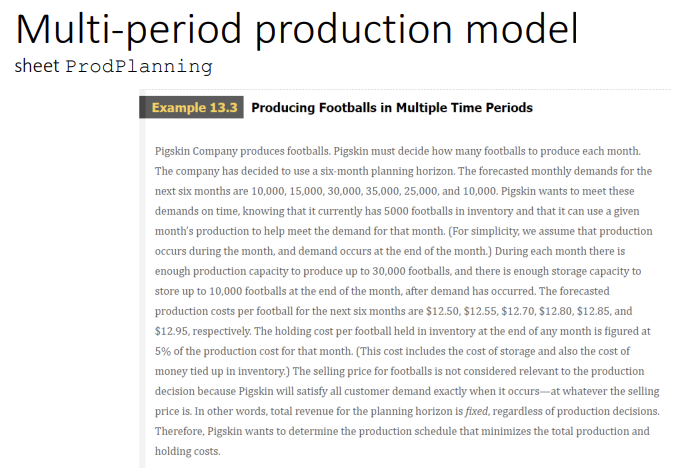

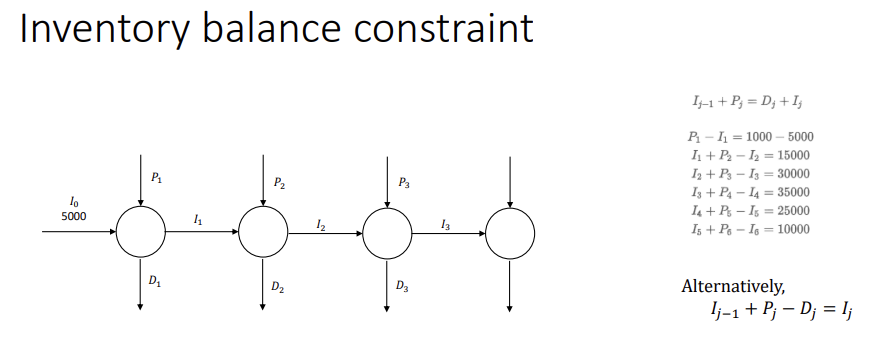

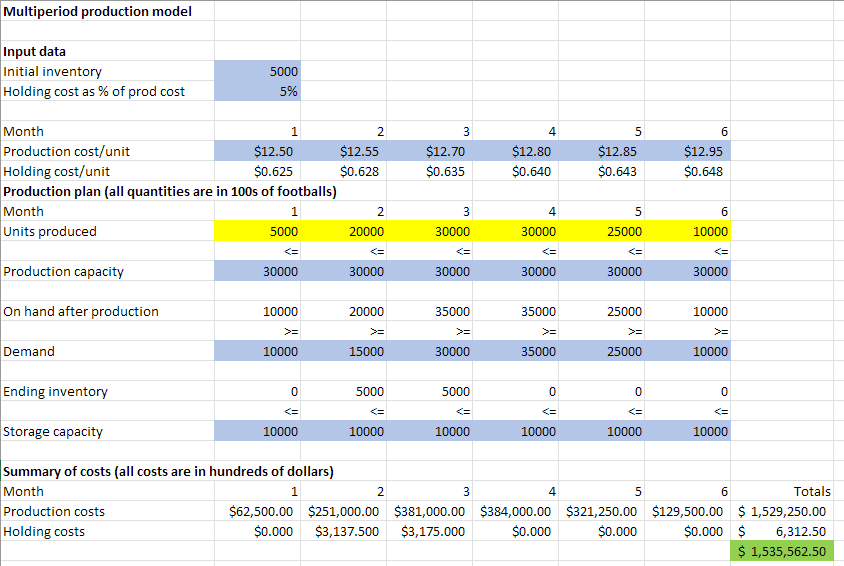

In [392]:
# input parameters
open_inv = 5000

periods = range(6)
prod_cost = np.array([12.5, 12.55, 12.7, 12.8, 12.85, 12.95])
hold_cost = prod_cost * 0.05
prod_cap = np.array([30000, 30000, 30000, 30000, 30000, 30000])
demand = np.array([10000, 15000, 30000, 35000, 25000, 10000])
storage_cap = np.array([10000, 10000, 10000, 10000, 10000, 10000])

# decision variables
x = LpVariable.matrix('x', range(1,7), lowBound=0)
x

[x_1, x_2, x_3, x_4, x_5, x_6]

In [393]:
"""
cumulative ending inventory
end_inv1: open_inv + x1-d1
end_inv2: end_inv1 + x2-d2
          open_inv + x1-d1 + x2-d2         -> open_inv + x1+x2 - (d1+d2)
end_inv3: end_inv2 + x3-d3
          open_inv + x1-d1 + x2-d2 + x3-d3 -> open_inv + x1+x2+x3 - (d1+d2+d3)
and so on
"""
def end_inv(n):
    if n < 0: 
        return open_inv
    else: 
        return open_inv + sum(x[:n+1]) - sum(demand[:n+1])

# cost for period 1
cost = x[0]*prod_cost[0] + end_inv(0)*holding_cost[0]
cost

13.125*x_1 + -3125.0

In [394]:
model = LpProblem('OperationCost', LpMinimize)

# Objective function: sum of cost over 6 periods
obj_func = lpSum([ x[i]*prod_cost[i] + end_inv(i)*hold_cost[i] for i in periods ])
print(f"Minimize: {obj_func}")
model += obj_func    

Minimize: 16.3175*x_1 + 15.7425*x_2 + 15.265*x_3 + 14.73*x_4 + 14.14*x_5 + 13.5975*x_6 - 250200.0


In [395]:
# Production capacity constraints
for i in periods:
    g = x[i] <= prod_cap[i]
    print(g)
    model += g

x_1 <= 30000
x_2 <= 30000
x_3 <= 30000
x_4 <= 30000
x_5 <= 30000
x_6 <= 30000


In [396]:
"""
# Demand constraint
period 1: open + x1
period 2: end_inv1 + x2
period 3: end_inv2 + x3
"""
def onhand_after_prod(n):
    return end_inv(n-1) + x[n]

for i in periods:
    g = onhand_after_prod(i) >= demand[i]
    print(g)
    model += g

x_1 >= 5000
x_1 + x_2 >= 20000
x_1 + x_2 + x_3 >= 50000
x_1 + x_2 + x_3 + x_4 >= 85000
x_1 + x_2 + x_3 + x_4 + x_5 >= 110000
x_1 + x_2 + x_3 + x_4 + x_5 + x_6 >= 120000


In [397]:
# Storage capacity constraint
for i in periods:
    g = end_inv(i) <= storage_cap[i]
    print(g)
    model += g

x_1 <= 15000
x_1 + x_2 <= 30000
x_1 + x_2 + x_3 <= 60000
x_1 + x_2 + x_3 + x_4 <= 95000
x_1 + x_2 + x_3 + x_4 + x_5 <= 120000
x_1 + x_2 + x_3 + x_4 + x_5 + x_6 <= 130000


In [398]:
model

OperationCost:
MINIMIZE
16.3175*x_1 + 15.7425*x_2 + 15.265*x_3 + 14.73*x_4 + 14.14*x_5 + 13.5975*x_6 + -250200.0
SUBJECT TO
_C1: x_1 <= 30000

_C2: x_2 <= 30000

_C3: x_3 <= 30000

_C4: x_4 <= 30000

_C5: x_5 <= 30000

_C6: x_6 <= 30000

_C7: x_1 >= 5000

_C8: x_1 + x_2 >= 20000

_C9: x_1 + x_2 + x_3 >= 50000

_C10: x_1 + x_2 + x_3 + x_4 >= 85000

_C11: x_1 + x_2 + x_3 + x_4 + x_5 >= 110000

_C12: x_1 + x_2 + x_3 + x_4 + x_5 + x_6 >= 120000

_C13: x_1 <= 15000

_C14: x_1 + x_2 <= 30000

_C15: x_1 + x_2 + x_3 <= 60000

_C16: x_1 + x_2 + x_3 + x_4 <= 95000

_C17: x_1 + x_2 + x_3 + x_4 + x_5 <= 120000

_C18: x_1 + x_2 + x_3 + x_4 + x_5 + x_6 <= 130000

VARIABLES
x_1 Continuous
x_2 Continuous
x_3 Continuous
x_4 Continuous
x_5 Continuous
x_6 Continuous

In [404]:
# Solve Model
model.solve()
print(f"Status: {LpStatus[model.status]}")
print(f"Objective value: {model.objective.value()}")

for i in periods:
    print(f"Period {i+1}: {x[i].value()}")

Status: Optimal
Objective value: 1535562.5
Period 1: 5000.0
Period 2: 20000.0
Period 3: 30000.0
Period 4: 30000.0
Period 5: 25000.0
Period 6: 10000.0


# Homework

## 4) Assignment problem

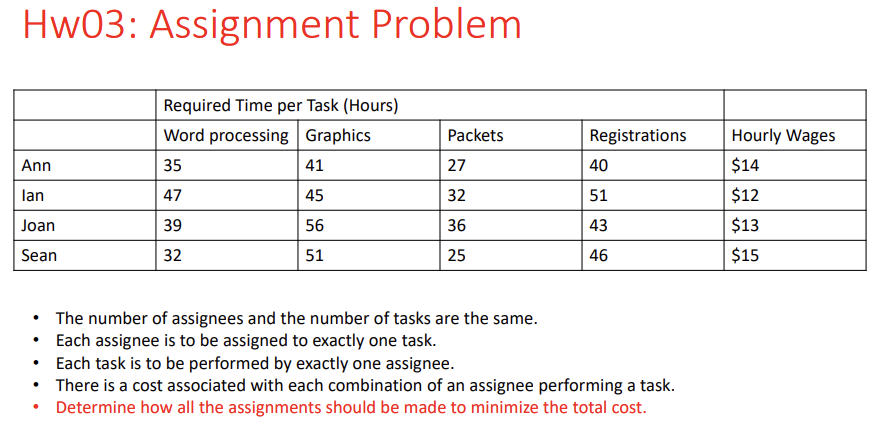

**Using Excel Solver**  
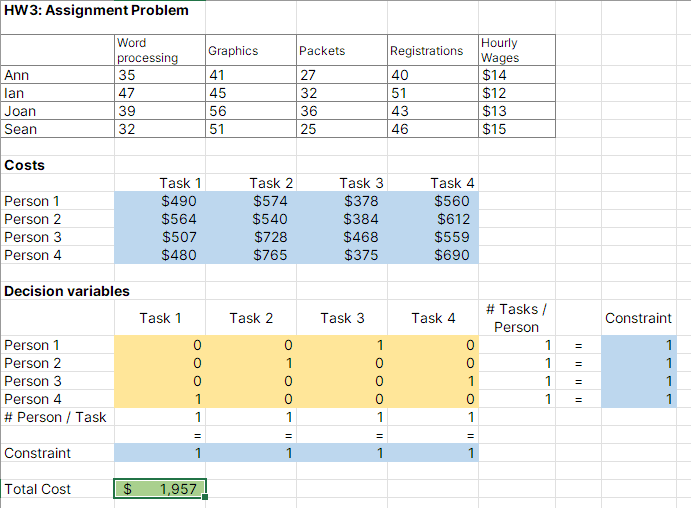

In [465]:
# inputs
tasks = ['Word Processing', 'Graphics', 'Packets', 'Registrations']
assignees = ['Ann','Ian','Joan','Sean']
df = pd.DataFrame([[35, 41, 27, 40, 14],
                   [47, 45, 32, 51, 12],
                   [39, 56, 36, 43, 13],
                   [32, 51, 25, 46, 15]], 
                   columns=tasks + ['Hourly Wages'],
                   index=assignees)
df

,Word Processing,Graphics,Packets,Registrations,Hourly Wages
Ann,35,41,27,40,14
Ian,47,45,32,51,12
Joan,39,56,36,43,13
Sean,32,51,25,46,15


In [466]:
# transform inputs
for i in range(4):
    # cost = hour spent for each task * hourly wage
    df.iloc[:,i] = df.iloc[:,i] * df.iloc[:,4]
df = df.iloc[:,:4].rename_axis('assignee').reset_index().melt(id_vars='assignee', var_name='task', value_name='cost')

costs = { (r['assignee'], r['task']): r['cost'] for i,r in df.iterrows() }
costs

{('Ann', 'Word Processing'): 490,
 ('Ian', 'Word Processing'): 564,
 ('Joan', 'Word Processing'): 507,
 ('Sean', 'Word Processing'): 480,
 ('Ann', 'Graphics'): 574,
 ('Ian', 'Graphics'): 540,
 ('Joan', 'Graphics'): 728,
 ('Sean', 'Graphics'): 765,
 ('Ann', 'Packets'): 378,
 ('Ian', 'Packets'): 384,
 ('Joan', 'Packets'): 468,
 ('Sean', 'Packets'): 375,
 ('Ann', 'Registrations'): 560,
 ('Ian', 'Registrations'): 612,
 ('Joan', 'Registrations'): 559,
 ('Sean', 'Registrations'): 690}

In [468]:
assignment = LpVariable.dicts('x', [(a,t) for a in assignees for t in tasks], lowBound=0)
assignment 

{('Ann', 'Word Processing'): x_('Ann',_'Word_Processing'),
 ('Ann', 'Graphics'): x_('Ann',_'Graphics'),
 ('Ann', 'Packets'): x_('Ann',_'Packets'),
 ('Ann', 'Registrations'): x_('Ann',_'Registrations'),
 ('Ian', 'Word Processing'): x_('Ian',_'Word_Processing'),
 ('Ian', 'Graphics'): x_('Ian',_'Graphics'),
 ('Ian', 'Packets'): x_('Ian',_'Packets'),
 ('Ian', 'Registrations'): x_('Ian',_'Registrations'),
 ('Joan', 'Word Processing'): x_('Joan',_'Word_Processing'),
 ('Joan', 'Graphics'): x_('Joan',_'Graphics'),
 ('Joan', 'Packets'): x_('Joan',_'Packets'),
 ('Joan', 'Registrations'): x_('Joan',_'Registrations'),
 ('Sean', 'Word Processing'): x_('Sean',_'Word_Processing'),
 ('Sean', 'Graphics'): x_('Sean',_'Graphics'),
 ('Sean', 'Packets'): x_('Sean',_'Packets'),
 ('Sean', 'Registrations'): x_('Sean',_'Registrations')}

In [475]:
model = LpProblem('Assignment', LpMinimize)
obj_func = lpSum([ assignment[(a,t)]*costs[(a,t)] for a in assignees for t in tasks])
print("Objective function\n", obj_func)
model += obj_func

Objective function
 574*x_('Ann',_'Graphics') + 378*x_('Ann',_'Packets') + 560*x_('Ann',_'Registrations') + 490*x_('Ann',_'Word_Processing') + 540*x_('Ian',_'Graphics') + 384*x_('Ian',_'Packets') + 612*x_('Ian',_'Registrations') + 564*x_('Ian',_'Word_Processing') + 728*x_('Joan',_'Graphics') + 468*x_('Joan',_'Packets') + 559*x_('Joan',_'Registrations') + 507*x_('Joan',_'Word_Processing') + 765*x_('Sean',_'Graphics') + 375*x_('Sean',_'Packets') + 690*x_('Sean',_'Registrations') + 480*x_('Sean',_'Word_Processing')


In [476]:
# Assignee constraitn - only one task for each assignee
for a in assignees:
    g = lpSum([assignment[(a,t)] for t in tasks]) == 1
    print(g)
    model += g

# Task constraint - only one person for each task
for t in tasks:
    g = lpSum([assignment[(a,t)] for a in assignees]) == 1
    print(g)
    model += g

x_('Ann',_'Graphics') + x_('Ann',_'Packets') + x_('Ann',_'Registrations') + x_('Ann',_'Word_Processing') = 1
x_('Ian',_'Graphics') + x_('Ian',_'Packets') + x_('Ian',_'Registrations') + x_('Ian',_'Word_Processing') = 1
x_('Joan',_'Graphics') + x_('Joan',_'Packets') + x_('Joan',_'Registrations') + x_('Joan',_'Word_Processing') = 1
x_('Sean',_'Graphics') + x_('Sean',_'Packets') + x_('Sean',_'Registrations') + x_('Sean',_'Word_Processing') = 1
x_('Ann',_'Word_Processing') + x_('Ian',_'Word_Processing') + x_('Joan',_'Word_Processing') + x_('Sean',_'Word_Processing') = 1
x_('Ann',_'Graphics') + x_('Ian',_'Graphics') + x_('Joan',_'Graphics') + x_('Sean',_'Graphics') = 1
x_('Ann',_'Packets') + x_('Ian',_'Packets') + x_('Joan',_'Packets') + x_('Sean',_'Packets') = 1
x_('Ann',_'Registrations') + x_('Ian',_'Registrations') + x_('Joan',_'Registrations') + x_('Sean',_'Registrations') = 1


In [478]:
# Solve Model
model.solve()
print(f"Status: {LpStatus[model.status]}")
print(f"Objective value: {model.objective.value()}")

Status: Optimal
Objective value: 1957.0


In [491]:
result = pd.DataFrame([(a, t, assignment[(a,t)].value()) for a in assignees for t in tasks], columns=['Assignee', 'Task', 'Assignment'])
result.pivot(index='Assignee', columns='Task', values='Assignment')[tasks]

Task,Word Processing,Graphics,Packets,Registrations
Assignee,,,,
Ann,0.0,0.0,1.0,0.0
Ian,0.0,1.0,0.0,0.0
Joan,0.0,0.0,0.0,1.0
Sean,1.0,0.0,0.0,0.0


## 5)  Distribution plan

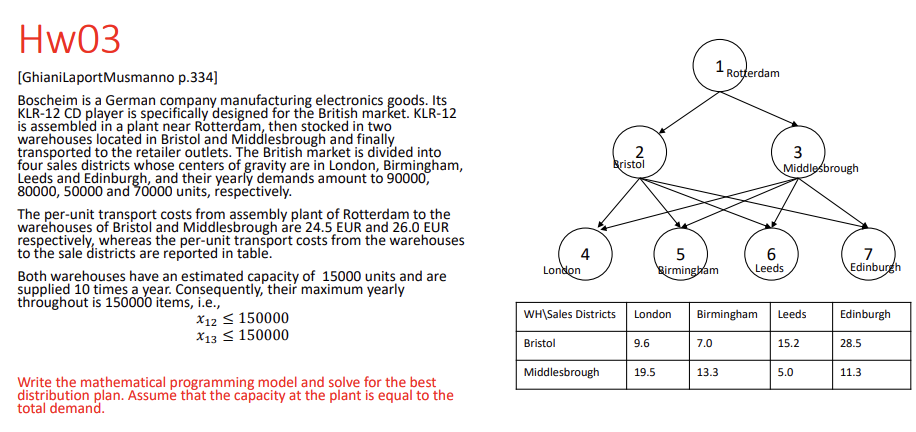

In this case, `Demand = Supply`, model the problem with `Minimum Cost Network Flow (MCNF)`. 

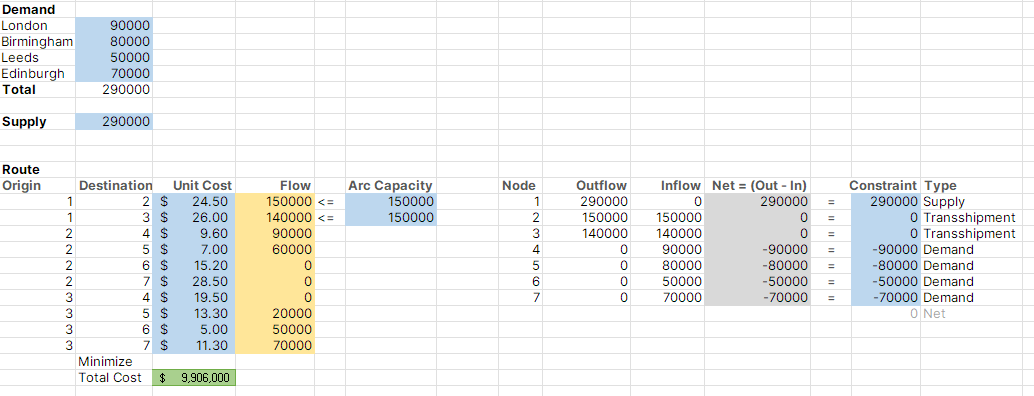

In [495]:
arcs = [(1,2), (1,3), (2,4), (2,5), (2,6), (2,7), (3,4), (3,5), (3,6), (3,7)] 
unit_costs = [24.5, 26, 9.6, 7, 15.2, 28.5, 19.5, 13.3, 5, 11.3]
costs = dict(zip(arcs, unit_costs))
costs

{(1, 2): 24.5,
 (1, 3): 26,
 (2, 4): 9.6,
 (2, 5): 7,
 (2, 6): 15.2,
 (2, 7): 28.5,
 (3, 4): 19.5,
 (3, 5): 13.3,
 (3, 6): 5,
 (3, 7): 11.3}

In [532]:
flow = LpVariable.dicts('x', [a for a in arcs], lowBound=0)
flow

{(1, 2): x_(1,_2),
 (1, 3): x_(1,_3),
 (2, 4): x_(2,_4),
 (2, 5): x_(2,_5),
 (2, 6): x_(2,_6),
 (2, 7): x_(2,_7),
 (3, 4): x_(3,_4),
 (3, 5): x_(3,_5),
 (3, 6): x_(3,_6),
 (3, 7): x_(3,_7)}

In [533]:
model = LpProblem('DistributionPlan', LpMinimize)
obj_func = lpSum([flow[a]*costs[a] for a in arcs])
print(obj_func)
model += obj_func

24.5*x_(1,_2) + 26*x_(1,_3) + 9.6*x_(2,_4) + 7*x_(2,_5) + 15.2*x_(2,_6) + 28.5*x_(2,_7) + 19.5*x_(3,_4) + 13.3*x_(3,_5) + 5*x_(3,_6) + 11.3*x_(3,_7)


In [534]:
# Arc capacity constraints
arc_cap = {
    (1,2): 150000,
    (1,3): 150000
}
for a in arc_cap:
    g = flow[a] <= arc_cap[a]
    print(g)
    model += g

x_(1,_2) <= 150000
x_(1,_3) <= 150000


In [535]:
# Net flow constraint
# Outflow - Inflow = b
netflows = { 1: 290000, 2: 0, 3: 0, 4: -90000, 5: -80000, 6: -50000, 7: -70000 }
for node, b in netflows.items():
    # net_outflow - net_inflow = b
    g = lpSum([flow[a] for a in arcs if a[0]==node]) - lpSum([flow[a] for a in arcs if a[1]==node]) == b
    print(g)
    model += g

x_(1,_2) + x_(1,_3) = 290000
-x_(1,_2) + x_(2,_4) + x_(2,_5) + x_(2,_6) + x_(2,_7) = 0
-x_(1,_3) + x_(3,_4) + x_(3,_5) + x_(3,_6) + x_(3,_7) = 0
-x_(2,_4) - x_(3,_4) = -90000
-x_(2,_5) - x_(3,_5) = -80000
-x_(2,_6) - x_(3,_6) = -50000
-x_(2,_7) - x_(3,_7) = -70000


In [536]:
model

DistributionPlan:
MINIMIZE
24.5*x_(1,_2) + 26*x_(1,_3) + 9.6*x_(2,_4) + 7*x_(2,_5) + 15.2*x_(2,_6) + 28.5*x_(2,_7) + 19.5*x_(3,_4) + 13.3*x_(3,_5) + 5*x_(3,_6) + 11.3*x_(3,_7) + 0.0
SUBJECT TO
_C1: x_(1,_2) <= 150000

_C2: x_(1,_3) <= 150000

_C3: x_(1,_2) + x_(1,_3) = 290000

_C4: - x_(1,_2) + x_(2,_4) + x_(2,_5) + x_(2,_6) + x_(2,_7) = 0

_C5: - x_(1,_3) + x_(3,_4) + x_(3,_5) + x_(3,_6) + x_(3,_7) = 0

_C6: - x_(2,_4) - x_(3,_4) = -90000

_C7: - x_(2,_5) - x_(3,_5) = -80000

_C8: - x_(2,_6) - x_(3,_6) = -50000

_C9: - x_(2,_7) - x_(3,_7) = -70000

VARIABLES
x_(1,_2) Continuous
x_(1,_3) Continuous
x_(2,_4) Continuous
x_(2,_5) Continuous
x_(2,_6) Continuous
x_(2,_7) Continuous
x_(3,_4) Continuous
x_(3,_5) Continuous
x_(3,_6) Continuous
x_(3,_7) Continuous

In [538]:
# Solve Model
model.solve()
print(f"Status: {LpStatus[model.status]}")
print(f"Objective value: {model.objective.value():,}")

Status: Optimal
Objective value: 9,906,000.0


In [539]:
result = pd.DataFrame([(a[0], a[1], flow[a].value()) for a in arcs], columns=['origin','destination','value'])
result

,origin,destination,value
0,1,2,150000.0
1,1,3,140000.0
2,2,4,90000.0
3,2,5,60000.0
4,2,6,0.0
5,2,7,0.0
6,3,4,0.0
7,3,5,20000.0
8,3,6,50000.0
9,3,7,70000.0
